# Empirical Validation II

In [89]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\Benessen vs Roemer\rbergomi'
os.chdir(path_folder)

from datetime import datetime, timedelta
from datetime import datetime as dt

import numpy as np
import math
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
import pandas as pd
import pickle
import pytz
from requests_html import HTMLSession
import scipy
import time
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
#% matplotlib inline

import NeuralNetworkPricing as nnp
import matplotlib.pyplot as plt 

import pandas_datareader.data as web
import scipy
import yfinance as yf

from yahoo_fin.options import get_options_chain, get_expiration_dates

In [2]:
def forward_price(spot, div, r, tau):
    """
    Input:
    spot = Spot Price
    div = sum of dividends to be paid until expiration of option contract at T
    r = Risk free rate
    tau = Time to Expiration (can be single number or array)
    
    Output:
    Forward Price F
    
    Computes the forward price, allows for single or array input
    """
    
    F = spot*np.exp(r*tau) - div*np.exp(r*tau)
    return F

In [3]:
def str_to_float(value):
    try:
        return np.float(value)
    except ValueError as ve:
        #print("value error: {}".format(ve))
        try:
            sepvals=value.split(",")
            fixed_val = np.float((sepvals[0])+(sepvals[1]))
            return fixed_val
        except Exception as e:
            #print("Normal exception: {}".format(e))
            pass
        
    except Exception as e:
        #print("Normal exception: {}".format(e))
        pass
vec_stf = np.vectorize(str_to_float)
    
def get_earnings_data(ticker):
    
    # Parse yahoo finance & scrape earnings data
    url = "https://finance.yahoo.com/calendar/earnings?symbol={}".format(ticker)
    session = HTMLSession()
    resp = session.get(url)
    html = resp.html.raw_html.decode()
    earnings_table = pd.read_html(html)[0]
    
    # Convert Data to readable format
    reported_values = [str_to_float(x) for x in earnings_table["Reported EPS"]]
    estimated_values = [str_to_float(x) for x in earnings_table["EPS Estimate"]]
    surprise_values = [str_to_float(x) for x in earnings_table["Surprise(%)"]]
    str_earnings = "%b %d, %Y, %I %p"
    datetime_data = [datetime.strptime(x[:-3], str_earnings) for x in earnings_table["Earnings Date"]]
    earnings_table["Reported EPS"] = reported_values
    earnings_table["EPS Estimate"] = estimated_values    
    earnings_table["Surprise(%)"] = surprise_values 
    earnings_table["Earnings Date"] = datetime_data
    return earnings_table

def price_div_hist_fun(ticker, date_str):
    # define ticker and get data
    ticker_object = yf.Ticker(ticker)
    price_div_hist = ticker_object.history(start='2010-01-01')
    # get spot
    close_price = price_div_hist['Close']
    spot = float(close_price[close_price.index==date_str])
    return spot, price_div_hist 
    
def dividend_estimation(ticker, year, date_str):
    
    earnings_table = get_earnings_data(ticker)
    _, price_div_hist = price_div_hist_fun(ticker, date_str)
    
    # Specify time range of dividend payments
    
    # calculate dividend payout ratio
    earnings_table_year = earnings_table[ ( earnings_table["Earnings Date"]> str(year)) & ( earnings_table["Earnings Date"] < str(year+1)) ]
    price_div_hist_year = price_div_hist[(price_div_hist.index > str(year)) & (price_div_hist.index < str(year+1))]
    
    cum_earnings = earnings_table_year["Reported EPS"].sum()
    cum_dividends = price_div_hist_year["Dividends"].sum()

    dividend_payout_ratio = cum_dividends/cum_earnings
        
    # unique years
    data = df_all_maturities["Maturity"]
    str_mat = "%B %d, %Y"
    list1 = [datetime.strptime(x, str_mat) for x in data]
    unique_years = set([x.year for x in list1])
    
    # Projected Dividends
    projected_earnings = earnings_table[earnings_table["Earnings Date"]>str(year+1)]
    projected_dividends = projected_earnings["EPS Estimate"]*dividend_payout_ratio
    projected_earnings.loc[:,"Div Estimate"] = projected_dividends
    
    # combining past and projected dividends
    div_hist_df = pd.DataFrame(index=price_div_hist.index)
    div_hist_df["Dividends"] = price_div_hist.Dividends
    div_est_df = pd.DataFrame(index=projected_earnings["Earnings Date"])
    div_est_df["Dividends"] = projected_earnings["Div Estimate"].values
    all_div_df = pd.concat([div_hist_df, div_est_df])
    return all_div_df
    
def find_pv_dividends(date_str, df_all_maturities, all_div_df, r):
    str_today = "%Y-%m-%d"
    today_dt = datetime.strptime(date_str, str_today)
    pv_dividend_list = list()

    for index0, row0 in df_all_maturities.iterrows():
        # Finding all (dividend) dates between time of observation and option chain maturity! 
        data_df = all_div_df[ (all_div_df.index > date_str) & (all_div_df.index < row0["Maturity"]) ]
        data_df.loc[:,"PV_dividends"] = np.zeros(len(data_df.index))

        # If no dividend payments fall within timeframe, do nothing
        div_sum = data_df.values.sum()
        if div_sum == 0: 
            sum_pv_dividends = 0
        # if there are dividend payments...
        else:
            # for each dividend payment
            for index, row in data_df.iterrows():
                divPayment = row["Dividends"]

                if not divPayment == 0:

                    time_in_years = (index - today_dt).days/252

                    row["PV_dividends"] = divPayment * np.exp(-r*time_in_years)

        sum_pv_dividends = data_df["PV_dividends"].sum()
        pv_dividend_list.append(sum_pv_dividends)
    df_all_maturities["PV Dividends"] = pv_dividend_list
    return df_all_maturities

#spot, _ = price_div_hist_fun(ticker, date_str)
#all_div_df = dividend_estimation(ticker, year, date_str)
#df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)   

In [4]:
def rbergomi_s(forward, strikes, texp, params):
    
    """
    Input: 
    forward = Forward Price
    strikes = Set of Strike prices for one(!) expiration
    texp = Time to Expiration
    params = rBergomi Parameters
    
    Output:
    rBivs = rBergomi IVs
    call_prices = rBergomi computed call prices
    rB = rBergomi model object
    FT = 20.000 Forward Price adjusted price realizations at T
    
    This function is able to compute the rBergomi IVs and other values for a single(!)
    expiration
    
    """
    
    alpha, eta, rho, xi = params
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 366

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 50000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    FT = ST*forward
    K = strikes #np.exp(strikes) #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(FT - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    try:
        rBivs = vec_bsinv(call_prices, forward, np.transpose([K]), rB.T)
    except ValueError:
        rBivs = np.zeros(len(K))
        
    return rBivs, call_prices, rB, FT

In [132]:
def rBergomi_vols(df, params, opt_slice=None):
    """
    input:
    df = dataframe with option data
    params = rBergomi parameters
    opt_slice = optimization slice, defining a slice of the df to be used
    
    output:
    rB_list =  rBergomi implied Volatilities
    
    This function is able to price multiple option chains
    """
    
    if opt_slice is not None:
        print("Optimization slice given")
        df = df[df["Maturity"].isin(opt_slice)]
    
    exp_dates_list = df["Tau"].unique()
    
    FT_list = list()
    call_prices_list = list()
    rB_list = list()
    
    for i, tau in enumerate(exp_dates_list):
        
        df_slice = df[df["Tau"]==tau]
        forward = df_slice["Fwd"].values[0]
        rBivs, c0, rB, FT = rbergomi_s(forward, df_slice["Strike"].values, tau, params)

        FT_list = [*FT_list, *np.squeeze(FT)]
        try:
            call_prices_list = [*call_prices_list, *np.squeeze(c0)]
        except Exception as e:
            print(e)
        rB_list = [*rB_list, *np.squeeze(rBivs)]

    return rB_list, df

In [141]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """
    Input:
    file_name = file name of loaded option data in pickle format
    expiration_dates = extracted dates of maturities for option data 
    loaded_dictionary = all available option data
    
    Output:
    df_all_maturities = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!
    """
    
    # Time of File
    date_str = file_name.split("_")[-1][:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        df_maturity_t = loaded_dictionary[val]["calls"]
        df_maturity_t["Maturity"] = val
        df_maturity_t["Tau"] = tau
        df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
    return df_all_maturities, t_datetime

def clean_contracts(df, t_datetime):
    """
    Input:
    df = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Output:
    df_clean = dataframe of cleaned data by liquidity and time of last trade
    df_unclean = dataframe with both liquid (clean) and illiquid (unclean) data
    
    Cleans the observed contracts according to liquidity and time of last price
    
    """
    
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    df2["Ask"] = vec_stf(df2["Ask"])
    df2["Bid"] = vec_stf(df2["Bid"])
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True
    
    # Calculate forward price for all contracts
    fwd_list = forward_price(spot, df2["PV Dividends"], r, df2["Tau"])
    df2.loc[:, "Fwd"] = fwd_list
    
    # Transform the reported IVs into usable float format
    yahoo_ivs = [str_to_float(x.split("%")[0])*0.01 for x in df2["Implied Volatility"].values]
    df2.loc[:, "Implied Volatility"] = yahoo_ivs
    
    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.5:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.5 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
    
    # Lastly drop all rows that have a no bid or ask information
    df2.loc[df2['Bid'] == 0, 'Keep'] = False
    df2.loc[df2['Ask'] == 0, 'Keep'] = False
    
    # Switch from unclean to clean data
    df_unclean = df2
    df_clean = df_unclean[df_unclean["Keep"]==True]
    
    cleaned_num = len(df) - len(df_clean)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean, df_unclean

## Function Execution

### Option Chain Info for Ticker

In [142]:
file_loc = r"C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\option_data"
ticker_list = ["AAPL", "GME", "MSFT", "NIO", "SPY", "T", "TSLA"]
ticker= ticker_list[5]
df_cleaned_all = pd.DataFrame()


#for ticker in ticker_list:
print("---------------")
print(ticker)
file_name =  "\optionsData_{}_2021-08-05.pkl".format(ticker)


date_str = file_name.split("_")[-1][:-4]
str_format1 = "%Y-%m-%d"
t_datetime = datetime.strptime(date_str, str_format1)

file_to_read = open(file_loc + file_name, "rb")
loaded_dictionary = pickle.load(file_to_read)
expiration_dates = [key for key in loaded_dictionary]

#Get Spot information
spot, _ = price_div_hist_fun(ticker, date_str)

# Download Discount Rate for black scholes models
start = dt(2010, 1, 1)
end = dt.today()
# DFF = https://fred.stlouisfed.org/series/DFF
# Effective federal funds rate
eff = web.DataReader("DFF", "fred", start, end) # in percent
r = eff.loc[date_str].DFF * 0.01 # in decimal places

"""
Here we calculate 
- the dataframe of only illiquid contracts
- BID/ASK/MID IVs
- Log Strike
- Log Moneyness

"""


# Combining all contracts for all maturities into one df
df_all_maturities, t_datetime = calculating_expiration(file_name, expiration_dates, loaded_dictionary)

# Add Dividend Information to df_all_maturities
year = 2021 # this sets the year for which dividend payout ratio is defined
all_div_df = dividend_estimation(ticker, year, date_str)
df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)   

# Cleaning the contracts
df_cleaned, df_uncleaned = clean_contracts(df_all_maturities, t_datetime)

# Dataframe of discarded option contracts
df_not_clean = df_uncleaned[~df_uncleaned.apply(tuple,1).isin(df_cleaned.apply(tuple,1))]

# As python is not able to compute the IVs within the functions above (potential bug?)
# we simply add those here:

# Finding BID/ASK/MID IVs for all contracts
try:
    bid_iv_vals = vec_bsinv(df_cleaned["Bid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
    ask_iv_vals = vec_bsinv(df_cleaned["Ask"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
    mid_iv_vals = vec_bsinv(df_cleaned["Mid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
except Exception as e:
    print(e)
    bid_iv_vals = list()
    ask_iv_vals = list()
    mid_iv_vals = list()
    for index, row in df_cleaned.iterrows():
        try:
            bid_iv_vals.append(bsinv(row["Bid"], row["Fwd"], row["Strike"], row["Tau"]))
        except Exception as e:
            bid_iv_vals.append(np.nan)
        try:
            ask_iv_vals.append(bsinv(row["Ask"], row["Fwd"], row["Strike"], row["Tau"]))
        except Exception as e:
            ask_iv_vals.append(np.nan)
        try:
            mid_iv_vals.append(bsinv(row["Mid"], row["Fwd"], row["Strike"], row["Tau"]))
        except Exception as e:
            mid_iv_vals.append(np.nan)




df_cleaned.loc[:, "Bid IVs"] = bid_iv_vals
df_cleaned.loc[:, "Ask IVs"] = ask_iv_vals
df_cleaned.loc[:, "Mid IVs"] = mid_iv_vals

# ------------------- This step is to take the yahoo reported IVs, whenever the MID IVs report erroneous values --------------------------------------------
mid_vols = df_cleaned["Mid IVs"].values
# This is a 1D array of true/false values given the condition at the end
condition=np.mod(mid_vols, 1)==1e-19
#this extracts the values from yahooivs, where mid-vols are close to zero
extractedvals = np.extract(condition, df_cleaned["Implied Volatility"].values)
# this inserts the yahoo ivs, in case the mid vols are close to zero in the correct position
np.place(mid_vols, mid_vols == 1e-19, extractedvals)

df_cleaned.loc[:, "Mid IVs"] = mid_vols
# ----------------------------------------------------------------------------------------------------------------------------------------------------------



# set log-strike column
log_strike = np.log(df_cleaned["Strike"]/df_cleaned["Fwd"])
df_cleaned.loc[:, "Log Strike"] = log_strike

# set log-moneyness column
log_moneyness = np.log(df_cleaned["Fwd"]/df_cleaned["Strike"])
df_cleaned.loc[:, "Log Moneyness"] = log_moneyness

# Set Ticker column
df_cleaned.loc[:,"Ticker"] = ticker

df_cleaned_all = pd.concat([df_cleaned_all, df_cleaned])


---------------
T


C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Number of deleted contracts:  90


### Time Series Parameters under P

In [143]:
def C_H_fun(H):
    value = np.sqrt(2*H*math.gamma(3/2-H) / ( math.gamma(H+1/2)*math.gamma(2-2*H) ) )
    return value

def eta_fun(H, nu):
    value = 2*nu*C_H_fun(H)/np.sqrt(2*H)
    return value


H_est = [0.110573, 0.092626, 0.146319, 0.039228, 0.170284, 0.110647, 0.089998]
nu_est = [0.577031, 0.626438, 0.520883, 0.637915, 0.568015, 0.568868, 0.607813]
rho_est = [-0.127195, 0.128399, -0.091008, 0.153142, -0.120013, -0.089833, -0.009374]

alpha_est= [x-0.5 for x in H_est]
eta_est = list()
for i, val in enumerate(nu_est):
    H = H_est[i]
    nu = val
    eta_est.append(eta_fun(H, nu))

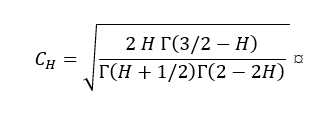

In [144]:
parameter_est_P_df = pd.DataFrame(index = ticker_list)
parameter_est_P_df["H_est"] = alpha_est
parameter_est_P_df["nu_est"] = eta_est
parameter_est_P_df["rho_est"] = rho_est
display(parameter_est_P_df)

,H_est,nu_est,rho_est
AAPL,-0.389427,0.933545,-0.127195
GME,-0.407374,0.993994,0.128399
MSFT,-0.353681,0.873635,-0.091008
NIO,-0.460772,0.950223,0.153142
SPY,-0.329716,0.974130,-0.120013
T,-0.389353,0.920411,-0.089833
TSLA,-0.410002,0.961631,-0.009374


In [145]:
parameter_est_P_df.loc[ticker].values

array([-0.389353  ,  0.92041058, -0.089833  ])

In [146]:
def objective_fun(xi):
    """
    Input:
    xi =  xi_t_i
    
    Fixed: Time series Parameters
    
    Output: 
    MSE between the rBergomi vols given by params and
    respective mid-price IVs
            
    """
    rberg_params = parameter_est_P_df.loc[ticker].values
    params_set = np.concatenate([rberg_params, xi])
    
    rBerg_vols, df = rBergomi_vols(df_timeslice, params_set)
    mid_vols = df["Mid IVs"].values
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

In [147]:
forward_variance_curve = list()

for i, tau in enumerate(df_cleaned_all["Tau"].unique()):
    
    # Initial Dataset
    df_timeslice = df_cleaned_all[df_cleaned_all["Tau"]==tau]
    bounds_xi = ((0.00001, 2.5),)
    xi=[0.125]
    try:
        MSE = objective_fun(xi)
        print("Initial MSE for {}: {}".format(tau, MSE))
        Results_xi = scipy.optimize.minimize(objective_fun, x0=0.125, method='L-BFGS-B', bounds=bounds_xi, tol=0.001, options={'maxiter': 500, 'disp': True})
        print("Optimized MSE for {}: {}".format(tau, Results_xi.fun))
        print("--- DONE ---")
        xi_new = Results_xi.x
    except Exception as e:
        print(e, "for {}".format(tau))
        xi_new = [0.125]
    
    forward_variance_curve = [*forward_variance_curve, *xi_new]

Initial MSE for 0.003: 5.677498026189533
Optimized MSE for 0.003: 1.8619413069665047
--- DONE ---
Initial MSE for 0.022: 0.14649945377385282
Optimized MSE for 0.022: 0.061902288250684306
--- DONE ---
Initial MSE for 0.041: 0.19615600612918546
Optimized MSE for 0.041: 0.1644228253691023
--- DONE ---
Initial MSE for 0.06: 0.008962619220410915
Optimized MSE for 0.06: 0.001957494664014232
--- DONE ---
Initial MSE for 0.079: 0.011287723626512678
Optimized MSE for 0.079: 0.007856098162753183
--- DONE ---
Initial MSE for 0.099: 0.01660309282616602
Optimized MSE for 0.099: 0.000498724679026558
--- DONE ---
Initial MSE for 0.118: 0.3229195576492577
Optimized MSE for 0.118: 0.1880857930403792
--- DONE ---
Initial MSE for 0.195: 0.2552173623768511
Optimized MSE for 0.195: 0.16667058256448358
--- DONE ---
Initial MSE for 0.463: 0.02048194494234407
Optimized MSE for 0.463: 0.020191312579793026
--- DONE ---
Initial MSE for 0.866: 0.02508266171142197
Optimized MSE for 0.866: 0.02493218919521038
--- D

In [ ]:
plt.plot(df_timeslice["Mid IVs"].values)

In [ ]:
plt.plot(df_timeslice["Implied Volatility"].values)
plt.plot(df_timeslice["Mid IVs"].values)
plt.plot(df_timeslice["Bid IVs"].values)
plt.plot(df_timeslice["Ask IVs"].values)
plt.plot(rBerg_vols)

In [ ]:
fixedparams = parameter_est_P_df.loc[ticker].values
xi_t = [forward_variance_curve[0]]
np.concatenate([fixedparams, xi_t])

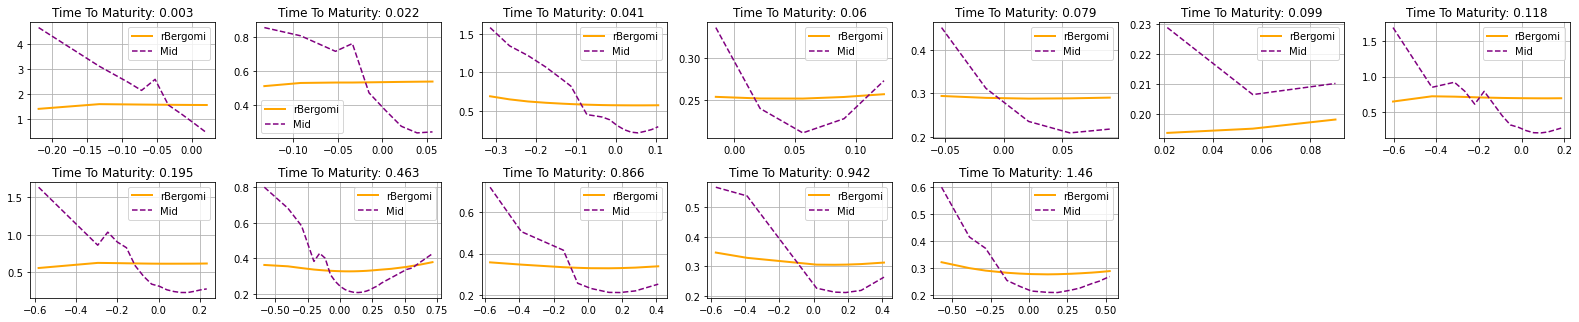

In [148]:
"""
Here we plot the full option chain for initial (manually calibrated) parameters

"""

plt.figure(figsize=(22,11))
j = -1
for i, tau in enumerate(df_cleaned_all["Tau"].unique()):
    j = j + 1
    plt.subplot(5,7,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned_all[df_cleaned_all["Tau"] == tau]
    
    # Calculating Forward Price
    forward = df_timeslice["Fwd"].values[0]
    
    # calc rBergomi IVs
    #rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, params_aapl)
    #rBivs = df_timeslice["rBergomi IVs"].values
    
    # Defining Parameters
    fixedparams = parameter_est_P_df.loc[ticker].values
    xi_t = forward_variance_curve[i]
    params_floating = np.concatenate([fixedparams, [xi_t]])
    
    # calc rBergomi IVs
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, params_floating)
    
    # Calculating log-strike
    logstrike = df_timeslice["Log Strike"].values
    
    # Calculating bid/ask bounds
    ask_iv_vals = df_timeslice["Ask IVs"].values 
    bid_iv_vals = df_timeslice["Bid IVs"].values 
    mid_iv_vals = df_timeslice["Mid IVs"].values
    iv_iv_vals = df_timeslice["Implied Volatility"].values
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, mid_iv_vals, '--', c="purple", label='Mid')
    #plt.plot(logstrike, iv_iv_vals, 'o', c="green", label='Mid')
    #plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    #plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(forward_variance_curve)

In [ ]:
"""
Here we plot the full option chain for initial (manually calibrated) parameters

"""

plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_aapl["Tau"].unique()):
    j = j + 1
    plt.subplot(4,5,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_aapl[df_aapl["Tau"] == tau]
    
    # Calculating Forward Price
    forward = df_timeslice["Fwd"].values[0]
    
    # calc rBergomi IVs
    #rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, params_aapl)
    #rBivs = df_timeslice["rBergomi IVs"].values
    
    # Defining Parameters
    fixedparams = parameter_est_P_df.loc[ticker].values
    xi_t = [forward_variance_curve[0]]
    params_floating = np.concatenate([fixedparams, xi_t])
    
    # calc rBergomi IVs
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, params_floating)
    
    # Calculating log-strike
    logstrike = df_timeslice["Log Strike"].values
    
    # Calculating bid/ask bounds
    ask_iv_vals = df_timeslice["Ask IVs"].values 
    bid_iv_vals = df_timeslice["Bid IVs"].values 
    mid_iv_vals = df_timeslice["Mid IVs"].values
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, mid_iv_vals, '--', c="purple", label='Mid')
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()